<a href="https://colab.research.google.com/github/astrfo/SRS-CH/blob/main/SRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRS-CH 実装

[満足化方策における非満足均衡を用いた確率的方策の検証] \\
https://www.jstage.jst.go.jp/article/pjsai/JSAI2021/0/JSAI2021_1G2GS2a04/_article/-char/ja/


[論文要約] \\
https://colab.research.google.com/drive/1PGbrYECAT7JiiOF_Zu0Sg8CzqjPTJE87#scrollTo=iaPmWlGNgFbd




In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [4]:
prob = np.random.rand(4)
print(f'prob: {prob}')
random.shuffle(prob)
print(f'shuffle: {prob}')

prob: [0.13883454 0.42268933 0.88310654 0.5976801 ]
shuffle: [0.88310654 0.13883454 0.5976801  0.42268933]


In [5]:
a = 1
result = 'even' if a % 2 == 0 else 'odd'
print(result)

odd


In [ ]:
class Environment(object):
    """
    K本の各腕の確率を生成
    当たりかハズレかを返す
    """

    def __init__(self, K):
        self._K = K
        self.prob = np.random.rand(K)

    def swap_prob(self):            # 2,000step毎に確率を入れ替える
        self.prob = self.prob

    def play(self, arm):
        result = 1 if self.prob[arm] > np.random.rand() else 0
        return result

In [ ]:
class TS(object):
    """
    Thompson Sampling
    """

    def __init__(self, K):
        self._K = K
        self._S = None      # Success
        self._F = None      # Failure

    def initialize(self):
        self._S = np.ones(self._K)
        self._F = np.ones(self._K)

    def select_arm(self):
        theta = np.array([np.random.beta(self._S[i], self._F[i]) for i in range(len(self._K))])
        arm = np.random.choice(np.where(theta == theta.max())[0])
        return arm

    def update(self, r, a):
        if r == 1: self._S[a] += 1
        else: self._F[a] += 1

In [ ]:
class RS_CH(object):
    """
    RS-CH
    """

    def __init__(self, K):
        self._K = K
        self.aleph = None
        self.RS = None

    def initialize(self, param):
        self.aleph = param
        self.RS = np.zeros(self._K)

    def select_arm(self, V, n, N):
        G = random.choice(np.where(V == V.max())[0])        # greedyな腕
        self.RS = (n / (N+1)) * (V - self.aleph)        # RS評価値の更新
        RSG = (n[G] / (N+1)) * (V[G] - self.aleph)     # RS[G]の全ての j に対して
        mu = np.exp(-n * self.D_KL(V, V[G]))        # μ^CHの計算 (24)
        mu[G] = 0.0
        self.aleph = V[G] * (1 - (V/V[G]) * mu) / (1 - mu)      # R^CHの計算 (25)
        np.nan_to_num(self.aleph, copy=False, nan=0)
        exceed_RSG_index = np.where(RSG <= self.RS)[0]     # RS[G]以上のindexを取り出す

        if len(exceed_RSG_index) == 1:     # RS[G]が最も高い
            arm = G
        else:
            if len(np.where(RSG < self.RS)[0]) == 1:     # RS[G] < RS[j]
                arm = np.where(RSG < self.RS)[0][0]
            else:
                exceed_mu = mu[exceed_RSG_index]
                max_mu_index = np.where(exceed_mu.max() == exceed_mu)[0]
                if len(max_mu_index) == 1:      # 最も高いμが1つだった場合はその腕を選択
                    arm = exceed_RSG_index[max_mu_index[0]]
                else:                                                        # 最も高いμが２つ以上だった場合
                    exceed_aleph = self.aleph[max_mu_index]
                    max_aleph_index = np.where(exceed_aleph.max() == exceed_aleph)[0]
                    if len(max_aleph_index) == 1:     # 最も高いalephが1つだった場合はその腕を選択
                        arm = exceed_RSG_index[max_mu_index[max_aleph_index[0]]]
                    else:                                                           # 最も高いalephが2つ以上だった場合はランダムに選択
                        arm = np.random.choice(exceed_RSG_index[max_mu_index[max_aleph_index]])
        return arm

    def D_KL(self, p, q):
        return p*np.log(p/q) + (1-p)*np.log( (1-p) / (1-q) )

In [ ]:
class RS_OPT(object):
    """
    RS-OPT
    """

    def __init__(self, K):
        self._K = K
        self.RS = None

    def initialize(self):
        self.RS = np.zeros(self._K)

    def select_arm(self, V, n, N):
        self.RS = (n / (N+1)) * (V - self.aleph)
        return np.random.choice(np.where(self.RS == self.RS.max())[0])

In [ ]:
class RSAgent(object):
    """
    経験期待値の更新
    RS価値関数の定義、更新
    選択肢を選ぶ
    """

    def __init__(self, K):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.policy = None
        self._r = None
        self._a = None

    def initialize(self, policy, param):
        self.policy = Policy(policy, param, self._K)        # RS評価値, aleph等の初期化
        self._V = np.array([0.5] * self._K)
        self._n = np.array([1e-8] * self._K)
        self._N = 0
        self._r = 0                                       # TSのパラメータ
        self._a = 0                                       # TSのパラメータ

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        self._n[arm] += 1
        self._N += 1
        self._r = reward
        self._a = arm

    def select_arm(self):
        return self.policy.act_policy(self._V, self._n, self._N, self._r, self._a)

In [ ]:
class Simulator(object):
    """
    シミュレーションを行う
    regretの計算
    regret,stepsをplot
    """
    
    def __init__(self, trial, step, K):
        self._algorithm = {"RS-CH": np.array([1.0] * K), 
                           "TS": np.array([1.0] * K), 
                           "RS-OPT": np.array([1.0] * K)}
        self._env = None
        self._prob = None
        self._trial = trial
        self._step = step
        self._K = K
        self._regret = np.zeros(step)
        self._regretV = None
        self.fig, self.ax = plt.subplots()

    def run(self):
        for algo, param in self._algorithm.items():
            start = time.time()
            self._agent = RSAgent(self._K)
            for t in range(self._trial):
                self._env = Environment(self._K)
                self._prob = self._env.prob
                self._agent.initialize(algo, param)
                if algo == 'RS-OPT': self._agent.policy.aleph = sum(sorted(self._prob, reverse=True)[:2]) / 2
                self._regretV = 0.0
                for s in range(self._step):
                    arm = self._agent.select_arm()
                    reward = self._env.play(arm)
                    self._agent.update(arm, reward)
                    self.calc_regret(t, s, arm)
            self.print_regret()
            elapsed_time = time.time() - start
            print(f'{algo}: {elapsed_time}[sec]')
        self.fig.tight_layout()
        plt.show()

    def calc_regret(self, t, s, arm):
        self._regretV += (self._prob.max() - self._prob[arm])
        self._regret[s] += (self._regretV - self._regret[s]) / (t+1)

    def print_regret(self):
        self.ax.plot(np.arange(self._step), self._regret, linestyle='dashed')
        self.ax.set_title(f'sim: {self._trial}, step: {self._step}, K: {self._K}')
        self.ax.set_xlabel("steps")
        self.ax.set_ylabel("regret")
        self.ax.legend(labels=self._algorithm.keys())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


RS-CH: 0.011161327362060547[sec]
TS: 0.010862350463867188[sec]
RS-OPT: 0.005592823028564453[sec]


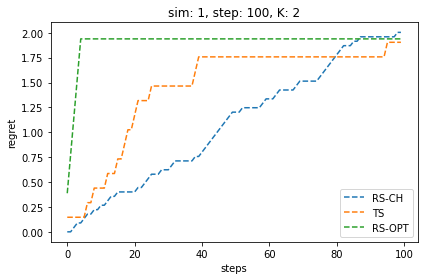

In [ ]:
def main():
    trial = 1
    step = 100
    K = 2
    sim = Simulator(trial, step, K)
    sim.run()



main()

In [ ]:
class Policy(object):
    """
    各方策の実行
    """

    def __init__(self, policy, param, K):
        if 'RS-CH' == policy:
            self.act_policy = self.RS_CH
            self.aleph = param
            self.RS = np.zeros(K)
        if 'RS-OPT' == policy:
            self.act_policy = self.RS_OPT
            self.aleph = param
            self.RS = np.zeros(K)
        if 'TS' == policy:
            self.act_policy = self.ThompsonSampling
            self._a = np.ones(K)
            self._b = np.ones(K)

    def D_KL(self, p, q):
        return p*np.log(p/q) + (1-p)*np.log( (1-p) / (1-q) )

    def RS_CH(self, V, n, N, *args):
        G = random.choice(np.where(V == V.max())[0])        # greedyな腕
        self.RS = (n / (N+1)) * (V - self.aleph)        # RS評価値の更新
        RSG = (n[G] / (N+1)) * (V[G] - self.aleph)     # RS[G]の全ての j に対して
        mu = np.exp(-n * self.D_KL(V, V[G]))        # μ^CHの計算 (24)
        mu[G] = 0.0
        self.aleph = V[G] * (1 - (V/V[G]) * mu) / (1 - mu)      # R^CHの計算 (25)
        np.nan_to_num(self.aleph, copy=False, nan=0)
        exceed_RSG_index = np.where(RSG <= self.RS)[0]     # RS[G]以上のindexを取り出す

        if len(exceed_RSG_index) == 1:     # RS[G]が最も高い
            arm = G
        else:
            if len(np.where(RSG < self.RS)[0]) == 1:     # RS[G] < RS[j]
                arm = np.where(RSG < self.RS)[0][0]
            else:
                exceed_mu = mu[exceed_RSG_index]
                max_mu_index = np.where(exceed_mu.max() == exceed_mu)[0]
                if len(max_mu_index) == 1:      # 最も高いμが1つだった場合はその腕を選択
                    arm = exceed_RSG_index[max_mu_index[0]]
                else:                                                        # 最も高いμが２つ以上だった場合
                    exceed_aleph = self.aleph[max_mu_index]
                    max_aleph_index = np.where(exceed_aleph.max() == exceed_aleph)[0]
                    if len(max_aleph_index) == 1:     # 最も高いalephが1つだった場合はその腕を選択
                        arm = exceed_RSG_index[max_mu_index[max_aleph_index[0]]]
                    else:                                                           # 最も高いalephが2つ以上だった場合はランダムに選択
                        arm = np.random.choice(exceed_RSG_index[max_mu_index[max_aleph_index]])
        return arm


    def RS_OPT(self, V, n, N, *args):
        self.RS = (n / (N+1)) * (V - self.aleph)
        return np.random.choice(np.where(self.RS == self.RS.max())[0])


    def ThompsonSampling(self, V, n, N, r, selected_arm):
        if N >= 1:                                          # N=0のときにバイアスがかからないように
            if r == 1: self._a[selected_arm] += 1
            else: self._b[selected_arm] += 1
        theta = np.array([np.random.beta(self._a[i], self._b[i]) for i in range(len(self._a))])
        arm = np.random.choice(np.where(theta == theta.max())[0])
        return arm